In [3]:
%matplotlib inline

from modsim import *

In [4]:
def make_system(beta, gamma):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(S=89, I=1, R=0)
    init /= np.sum(init)

    t0 = 0
    t_end = 7 * 14

    return System(init=init, t0=t0, t_end=t_end,
                  beta=beta, gamma=gamma)

In [5]:
def plot_results(S, I, R):
    """Plot the results of a SIR model.
    
    S: TimeSeries
    I: TimeSeries
    R: TimeSeries
    """
    plot(S, '--', color='blue', label='Susceptible')
    plot(I, '-', color='red', label='Infected')
    plot(R, ':', color='green', label='Resistant')
    decorate(xlabel='Time (days)',
             ylabel='Fraction of population')

In [6]:
def calc_total_infected(system):
    """Fraction of population infected during the simulation.
    
    system: System object with results.
    
    returns: fraction of population
    """
    frame = system.results
    return frame.S[system.t0] - frame.S[system.t_end]

In [7]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
    
    Add a TimeFrame to the System: results
    
    system: System object
    update_func: function that updates state
    """
    unpack(system)
    
    frame = TimeFrame(columns=init.index)
    frame.loc[t0] = init
    
    for i in linrange(t0, t_end):
        frame.loc[i+1] = update_func(frame.loc[i], system)
    
    system.results = frame

In [8]:
def update1(state, system):
    """Update the SIR model.
    
    state: State (s, i, r)
    system: System object
    
    returns: State (sir)
    """
    s, i, r = state

    unpack(system)
    
    infected = beta * i * s    
    recovered = gamma * i
    
    s -= infected
    i += infected - recovered
    r += recovered
    
    return State(S=s, I=i, R=r)

In [9]:
system = make_system(0.333, 0.25)
run_simulation(system, update1)
system.results.head()

,S,I,R
0,0.988889,0.011111,0.000000
1,0.985230,0.011992,0.002778
2,0.981296,0.012929,0.005776
3,0.977071,0.013921,0.009008
4,0.972541,0.014970,0.012488


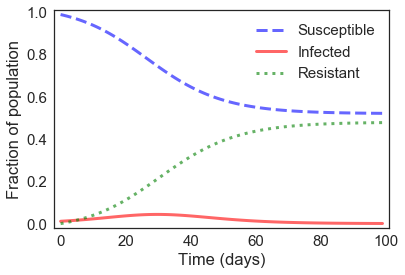

In [16]:
frame = system.results
plot_results(frame.S, frame.I, frame.R)

In [17]:
beta_array = linspace(0.1, 0.9, 11)
gamma = 0.25

In [21]:
for beta in beta_array:
    system = make_system(beta, gamma)
    run_simulation(system, update1)
    system.beta, calc_total_infected(system)

In [22]:
def sweep_beta(beta_array, gamma):
    """SweepSeriess a range of values for beta.
    
    beta_array: array of beta values
    gamma: recovery rate
    
    returns: SweepSeries that maps from beta to total infected
    """
    sweep = SweepSeries()
    for beta in beta_array:
        system = make_system(beta, gamma)
        run_simulation(system, update1)
        sweep[system.beta] = calc_total_infected(system)
    return sweep

In [23]:
infected_sweep = sweep_beta(beta_array, gamma)

Saving figure to file chap06-fig01.pdf


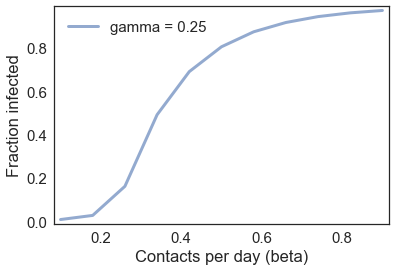

In [24]:
label = 'gamma = ' + str(gamma)
plot(infected_sweep, label=label)
decorate(xlabel='Contacts per day (beta)',
         ylabel='Fraction infected')

savefig('chap06-fig01.pdf')